# Groep Opdracht Week 4 Zoekmachines

## Students: Jasper van Eck, Ghislaine, Joris Galema, Lotte
## Student IDs: 6228194, 10996087, 11335165, 11269642


# Table of Content<a name='Top'></a>
[Import data](#ImportData)

[Create the TF Dict](#TFDict)

[Create the TF-IDF and Normalize](#TFIDFNorm)

[Vectorize Query](#InputQuery)

[Results](#Results)

- [WordCloud](#WordCloud) Requirement 3
- [Interact with Filters](#Filters) Requirements 1, 2, 4 and 5

[Cohen's Kappa](#Cohen) Requirement 6



# Import Data<a name='ImportData'></a>

In [60]:
#Imports
import pandas as pd
import math
import numpy as np
from elasticsearch import Elasticsearch
import nltk
import PIL
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import json
from collections import Counter, defaultdict
from sklearn import preprocessing
from datetime import datetime
import operator
import inspect

In [3]:
pd.set_option('display.max_colwidth', -1)

#Open & read JSON file
#Init empty list for json data to be stored
jsonDataReviews = []
with open('IMDB_reviews.json') as json_file:
    #Loop through lines in json file, each review is on seperate line
    for line in json_file:
        #Append to the list of json data
        jsonDataReviews.append(json.loads(line))

#Read the data from the json file
dataReviews = pd.DataFrame(jsonDataReviews)

#Add Review_id column
#Create index range
review_id = list(range(len(dataReviews)))
#Insert the index range into the DF
dataReviews.insert(0,'review_id',review_id,True)
#Cast to string from obj
dataReviews['review_summary'] = dataReviews['review_summary'].astype(str)
dataReviews['review_text'] = dataReviews['review_text'].astype(str)
#Cast to int from str
dataReviews['rating'] = dataReviews['rating'].astype(int)
#Cast to bool from obj
dataReviews['is_spoiler'] = dataReviews['is_spoiler'].astype(bool)
#Create datetime objects from the review_date string
dataReviews['review_date'] = [datetime.strptime(dateString, '%d %B %Y') for dateString in dataReviews['review_date'].values]

In [4]:
#Open & read TSV file with movie details
dataMovies = pd.read_csv('data.tsv', sep='\t', header=0, dtype={'tconst':str,'titleType':str,
                                                                'primaryTitle':str,'OriginalTitle':str,
                                                                'isAdult':str,'startYear':str,'endYear':str,
                                                                'runtimeMinutes':str,'genres':str})

In [5]:
movieTitles = dataMovies[dataMovies['tconst'].isin(dataReviews['movie_id'].values)]
movieTitles.head(1)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
18072,tt0012349,movie,The Kid,The Kid,0,1921,\N,68,"Comedy,Drama,Family"


In [6]:
#Replace the movie_id with the movie name
movieTitlesInsertList = [movieTitles[movieTitles['tconst']==movie_id]['primaryTitle'].values[0] for movie_id in dataReviews['movie_id'].values]
dataReviews.insert(7, 'movie_title', movieTitlesInsertList, True)

In [7]:
#Example of data
dataReviews.head(10)

review_id review_date   movie_id     user_id  is_spoiler  \
0  0         2006-02-10   tt0111161  ur1898687   True         
1  1         2000-09-06   tt0111161  ur0842118   True         
2  2         2001-08-03   tt0111161  ur1285640   True         
3  3         2002-09-01   tt0111161  ur1003471   True         
4  4         2004-05-20   tt0111161  ur0226855   True         
5  5         2004-08-12   tt0111161  ur1532177   True         
6  6         2005-10-09   tt0111161  ur6574726   True         
7  7         2012-02-04   tt0111161  ur31182745  True         
8  8         2008-10-24   tt0111161  ur9871443   True         
9  9         2011-07-30   tt0111161  ur2707735   True         

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

# Create the TF Dict<a name='TFDict'></a>

[Top](#Top)

In [8]:
#Init a default dict
tfDict = defaultdict(lambda: defaultdict(int))

#Init Porter Stemmer
ps = nltk.stem.PorterStemmer()

#Use less reviews to reduce runtimes for testing/practice
dataReviewsLess = dataReviews.head(50000).copy()

#Retrieve the actual reviews
reviewTexts = dataReviewsLess['review_text'].values

#Loop through reviews
for i in range(len(reviewTexts)):
    #Tokenize reviews and lowercase the text
    line = re.split('\W+',reviewTexts[i].lower())
    #Loop through tokens in review
    for word in line:
        #Stem token
        stem = ps.stem(word)
        #Increment frequency
        tfDict[stem][i] += 1

#Add in Corpus Frequency, Document Frequency and reposition the frequencies per document
tfDictXtra = defaultdict(lambda: defaultdict(int))
for word in tfDict:
    tfDictXtra[word]['CorpusFreq'] = sum(tfDict[word].values())
    tfDictXtra[word]['DocFreq'] = len(tfDict[word])
    tfDictXtra[word]['Freq_per_doc'] = tfDict[word]


# Create the TF-IDF and Normalize<a name='TFIDFNorm'></a>

[Top](#Top)

In [9]:
#Get the total number of reviews/documents
totalDocs = len(dataReviewsLess)

#Total unique words
totalUniqueWords = len(tfDictXtra)

#Create np matrix with zeros
tfIdf = np.zeros((totalUniqueWords,totalDocs))

#Create dataframe of words with index list to get the word position in matrix for future reference
wordsIndex = pd.DataFrame(list(tfDictXtra.keys()),columns=['Words'])
#Create index range
wordID = list(range(totalUniqueWords))
#Insert the index range
wordsIndex.insert(0,'Index',wordID,True)
#Index counter, to keep track of location in word list
wordCounter = 0


#loop through words in dict
for word in tfDictXtra:
    #Loop through frequencies of word in a doc from dict; LET OP deze regel geeft soms AttributeError: 'int' object has no attribute 'keys'
    #run de vorige cellen dan weer even opnieuw. Dat verhelpt t meestal
    dictLoop = list(tfDictXtra[word]['Freq_per_doc'].keys())
    for doc in dictLoop:
        #Calculate the TF-IDF
        tfIdf[wordCounter,doc] = tfDictXtra[word]['Freq_per_doc'][doc]*math.log((totalDocs/(1+tfDictXtra[word]['DocFreq'])))
    wordCounter += 1


In [10]:
#Transpose the tfIdf matrix and normalize, since the normalize works on rows, and we need to normalize the columns
tfIdfNorm = preprocessing.normalize(tfIdf.T, norm='l2')

# Vectorize query<a name='InputQuery'></a>

[Top](#Top)

In [47]:
#Starting/test query
query = "Inception is weird"

#Create a normalized vector of query
def vectorizeQuery(query):
    #Create empty base vector for Term Freq
    queryVector = np.zeros(totalUniqueWords)
    #Tokenize and make lowercase
    line = re.split('\W+',query.lower())
    #Loop through words
    for word in line:
        #Stem each word
        stem = ps.stem(word)
        #Increase term freq of query term
        queryVector[wordsIndex[wordsIndex['Words']==stem]['Index'].values] += 1
    
    #Create empty base vector for TF-IDF
    queryVectorTfIdf = np.zeros(totalUniqueWords)
    #Loop through TF vector of query
    for i in range(len(queryVector)):
        #Act where a term frequency was recorded
        if queryVector[i] != 0:
            #Determine the which word it was based on the index
            word = str(wordsIndex[wordsIndex['Index']==i]['Words'].values)
            #Calculate the TF-IDF
            queryVectorTfIdf[i] = queryVector[i]*math.log((totalDocs/(1+tfDictXtra[word]['DocFreq'])))
    
    #Make the TF-IDF vector a unit vector
    length = np.sqrt(queryVectorTfIdf.dot(queryVectorTfIdf))
    queryVectorNorm = queryVectorTfIdf/length
    
    #Return the unit vector
    return queryVectorNorm


In [48]:
#Cosine similarity matching
def cosineSim(vector, docVector):
    #Only dot product needed since vectors are already unit vectors and therefore the lengths are 1
    return vector.dot(docVector)#/(length vector * length docVector)
    
def rankedList(queryVector):
    #Create empty score list
    scoreList = np.zeros(totalDocs)
    #Loop through each doc
    for i in range(len(tfIdfNorm)):
        #Calculate for each doc the cosine sim. Index of scoreList = review_id
        scoreList[i] = cosineSim(queryVector,tfIdfNorm[i])
    
    #Create new data frame for ranked list based on smaller DF of data
    rankedDocList = dataReviewsLess.copy()
    #Insert the similarity score for each review
    rankedDocList.insert(0,'Score',scoreList,True)
    #Sort the review similarity based on the score and return
    return rankedDocList.sort_values(by='Score',ascending=False)

In [49]:
#Create the ranking list
rankings = rankedList(vectorizeQuery(query))

# Results<a name='Results'></a>

[Top](#Top)

### WordCloud <a name='WordCloud'></a>

[Top](#Top)

In [50]:
#Source: https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = "WordCloud of Query Results"):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=40,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

@interact
def showingWordcloudsOfKRanking(k=(1,50,1)):
    show_wordcloud(rankings.head(k)['review_text'])
    

@interact
def showingWordCloudOfOneReview(i=(1,len(dataReviewsLess),1)):
    show_wordcloud(dataReviewsLess[dataReviewsLess['review_id']==i]['review_text'].values,'WordCloud of a review')

interactive(children=(IntSlider(value=25, description='k', max=50, min=1), Output()), _dom_classes=('widget-in…

interactive(children=(IntSlider(value=25000, description='i', max=50000, min=1), Output()), _dom_classes=('wid…

### Interact with Filters<a name='Filters'></a>

[Top](#Top)

In [51]:
#Function to filter on the variables created by interact widget
def showResultsTime(start_date, end_date, AmountResults, AtleastRating, spoiler, movie_title):
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    if movie_title == 'None':
        if spoiler == 'Both':
            return rankings[(rankings.review_date > start_date) 
                        & (rankings.review_date < end_date) 
                        & (rankings.rating >= AtleastRating)].head(AmountResults)
        elif spoiler == 'Yes':
            return rankings[(rankings.review_date > start_date) 
                        & (rankings.review_date < end_date) 
                        & (rankings.rating >= AtleastRating)
                        & (rankings.is_spoiler == True)].head(AmountResults)
        elif spoiler == 'No':
            return rankings[(rankings.review_date > start_date) 
                        & (rankings.review_date < end_date) 
                        & (rankings.rating >= AtleastRating)
                        & (rankings.is_spoiler == False)].head(AmountResults)
    else:
        if spoiler == 'Both':
            return rankings[(rankings.review_date > start_date) 
                        & (rankings.review_date < end_date) 
                        & (rankings.rating >= AtleastRating)
                        & (rankings.movie_title == movie_title)].head(AmountResults)
        elif spoiler == 'Yes':
            return rankings[(rankings.review_date > start_date) 
                        & (rankings.review_date < end_date) 
                        & (rankings.rating >= AtleastRating)
                        & (rankings.is_spoiler == True)
                        & (rankings.movie_title == movie_title)].head(AmountResults)
        elif spoiler == 'No':
            return rankings[(rankings.review_date > start_date) 
                        & (rankings.review_date < end_date) 
                        & (rankings.rating >= AtleastRating)
                        & (rankings.is_spoiler == False)
                        & (rankings.movie_title == movie_title)].head(AmountResults)

#Sort the movieTitles DF
tmp = movieTitles.sort_values(by='primaryTitle')
#Prep a list of movie titles for filter
titles = ['None']
titles.extend(tmp['primaryTitle'].values)
#The interact function for faceted search
_ = interact(showResultsTime,
             start_date=widgets.DatePicker(value=pd.to_datetime('2014-01-01')),
             end_date=widgets.DatePicker(value=pd.to_datetime('2019-01-01')),
             AmountResults=(10, 100, 10),
             AtleastRating=(1,10,1),
             spoiler=['Both','Yes','No'],
             movie_title=titles)

interactive(children=(DatePicker(value=Timestamp('2014-01-01 00:00:00'), description='start_date'), DatePicker…

## Cohen's Kappa<a name='Cohen'></a>
[Top](#Top)

In [16]:
query1judge = np.array([[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]])
query2judge = np.array([[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]])
query3judge = np.array([[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]])
query4judge = np.array([[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]])
query5judge = np.array([[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]])

def AveragePrecision(ranked_list_of_results, list_of_relevant_objects):
    begin = 1/len(list_of_relevant_objects)
    count = 0
    for i, res in enumerate(ranked_list_of_results):
        for j, obj in enumerate(list_of_relevant_objects):
            if obj == res:
                itera = (j+1) / (i+1)
            count = count + itera
    return begin * count

def PE(data):
    '''On input data, return the P(E) (expected agreement).'''
    relevant = 0
    nonrelevant = 0
    # Iterate over the data
    for i in data:
        for j in i:
            
            # Top up the relevant documents by one if 1 is encountered
            if j == 1:
                relevant += 1
            # Top up the nonrelevant documents by one if 0 is encountered
            if j == 0:
                nonrelevant += 1

    # Calculates the total of inspected documents for the judges combined
    total = len(data)*2

    # Calculates the pooled marginals
    rel = relevant/total
    nonrel = nonrelevant/total

    # Calculates the P(E)
    P_E = nonrel**2 + rel **2    
    return    P_E 


def kappa(data, P_E):
    agree = 0
    for i in data:
        temp = None
        for j in i:
            if temp == j:
                agree += 1
            temp = j
    P_A = agree / len(data)
    kappa = (P_A - P_E)/(1 - P_E)   
    return kappa




## Graph of Timestamps Hits<a name='Cohen'></a>
[Top](#Top)

ValueError: `bins` must increase monotonically, when an array

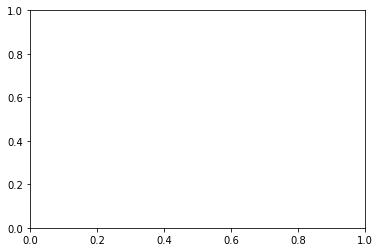

In [61]:
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

def count_occurences(movietitles):
    count = Counter(movietitles) 
    # sort the words from highest to lowest (first one is the highest rank)
    sorted_count = sorted(count.items(), key=operator.itemgetter(1), reverse=True)
    #gives the list of occurences and not the words
    occurences = []
    for i in sorted_count:
        occurences.append(i[1])
    return occurences

def plot_hist(lists):
    y = count_occurences(lists)
    x = np.arange(len(y))
    
    # get name x label
    xlabel = retrieve_name(lists)
     
    
    #plots the graph of word frequency versus rank of a word in this corpus
    plt.hist(x,y)
    plt.xlabel(xlabel)
    plt.ylabel('Occurancies')
    plt.show()

plot_hist(dataReviews['review_date'])

plot_hist(movieTitle['primaryTitle'])